In [2]:
from __future__ import annotations
from IPython.display import clear_output
clear_output(wait=True)  # wait=True waits for new output before clearing
#...
from pathlib import Path
from safetensors.torch import load_file
import itertools
from pydantic import BaseModel, ConfigDict
import numpy as np
import tqdm
import torch
from typing import List, Tuple, Literal, Dict

DATASETS = [
    # (numbers are counts for documents, there may be some longer documents -> slightly more chunks)
    "arguana", # 10K
    "fiqa", # 50K -> 20K
    "scidocs", # 25K -> 20K
    "nfcorpus", # 5K
    "hotpotqa", # 100K -> 20K
    "trec-covid", # too much -> 20K
]

MODEL_NAMES = [
    "WhereIsAI/UAE-Large-V1",
    "BAAI/bge-base-en-v1.5",
    "BAAI/bge-large-en-v1.5",
    "BAAI/bge-small-en-v1.5",
    "intfloat/e5-base-v2",
    "intfloat/e5-large-v2",
    "intfloat/e5-small-v2",
    "thenlper/gte-base",
    "thenlper/gte-large",
    "thenlper/gte-small",
    "sentence-transformers/gtr-t5-base",
    "sentence-transformers/gtr-t5-large",
    "mixedbread-ai/mxbai-embed-large-v1",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/sentence-t5-large",
    "openai/text-embedding-3-large", # openai
    "openai/text-embedding-3-small", # openai
]

"""
TODO(Adriano) finish this (it might turn into a jupyter notebook idk)

This is an offline script to basically do the same thing as `quadracopter.ipynb`. It will provide functionality (through
multiple click commands) to:
1. Train optimal OLS and batched OLS for all pairs of embedding spaces, speeding up acquisition of our results by 1000x
2. Be able to calculate a set of visualizations that we need for the paper and store them somewhere
    - MAE Table
    - MSE Table
    - Variance Explained Table
    - MAE Explained Table
    - Aggregated of the above (using harmonic/arithmetic means)
    - CKA, Ranking Jaccard Similarity, and Rank score (to compare with the previous tables)
        - Cluster for CKA like the old paper
        - Sample a few random pairs of models and dataset and showcase the triplet loss
        - Cherry pick rank similarity from one model to all others and same for Jaccard like in the paper (this is done both in the
            bofore stitch section and in the after stitch section)
        - Table of rank similarity and jaccard similarity over top 10
    - Kernel maps
        - Sample a few random pairs of models and dataset and showcase the triplet loss
    - UMAP, PCA, and t-SNE for embeddings (combined with a clustering algorithm to get some labels on this shit)
        - Bonus: find some relevant labels for the chunks and then add that in there?
    - MSE/MAE of single cycle
    - Randomly sample some different transformations and calculate over-cycle performance (i.e. so we can see how long
        it takes to get error up by some percent like a half-life -> geometric mean)
    - Random matrix controls for CKA, Jaccard, MAE, MSE, etc... with sampling to provide error bars
(parses outputs from OLS or GD outputs and then creates this shit)
"""


paths_gd = [
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/arguana_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/nfcorpus_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/scidocs_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/trec-covid_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/fiqa_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/hotpotqa_hf_cartesian_product"),
]
paths_ols = [
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/ols_all_datasets")
]

class LossResultsLineEntry(BaseModel):
    epoch: int
    train_mse: float
    train_mae: float
    test_mse: float
    test_mae: float

class LossResults(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    train_mses: torch.Tensor
    train_maes: torch.Tensor
    validation_mses: torch.Tensor
    validation_maes: torch.Tensor

class StitchPair(BaseModel):
    source: str
    target: str
    dataset: str
    mode: Literal["affine", "affine_ols"] = "affine" 

class TableCreator:
    def __init__(self, paths: List[Path]):
        self.paths = paths

    def __load_stitch_info(self, path: Path) -> StitchPair:
        name = "stitch_info.json" if (path / "stitch_info.json").exists() else "stitch_info_pairs.json"
        with open(path / name, "r") as f:
            return StitchPair.model_validate_json(f.read())

    def __load_loss_results(self, path: Path) -> LossResults:
        with open(path / "log.jsonl", "r") as f:
            les = [LossResultsLineEntry.model_validate_json(line.strip()) for line in f if len(line.strip()) > 0]
        return LossResults(
            train_mses=torch.tensor([le.train_mse for le in les]),
            train_maes=torch.tensor([le.train_mae for le in les]),
            validation_mses=torch.tensor([le.test_mse for le in les]),
            validation_maes=torch.tensor([le.test_mae for le in les]),
        )

    def __get_minimal_mse_mae(self, loss_results: LossResults) -> torch.Tensor:
        train_mse, validation_mse = torch.min(loss_results.train_mses).item(), torch.min(loss_results.validation_mses).item()
        train_mae, validation_mae = torch.min(loss_results.train_maes).item(), torch.min(loss_results.validation_maes).item()
        return train_mse, validation_mse, train_mae, validation_mae

    def get_all_table_elements(self) -> Tuple[Dict[str, int], Dict[str, int], Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
        """
        Get a table of the minimal MSE and MAE out of all the models and datasets.
        """
        ################ 1. Load parent paths and sanity test ################
        jsonl_files = []
        # NOTE: log.jsonl = losses
        for path in self.paths:
            jsonl_files.extend(list(path.glob("**/*.jsonl")))
        # ---- Sanity Check Files Present ----
        parents = set([jsonl_file.parent for jsonl_file in jsonl_files])
        assert all((p / "log.jsonl").exists() for p in tqdm.tqdm(parents)) # get the losses that we will plit (i.e. MSEs and MAEs)
        assert all((p / "stitch_info.json").exists() or (p / "stitch_info_pairs.json").exists() for p in tqdm.tqdm(parents)) # get information about pair of models, etc...
        # TODO(Adriano) it appears that in some cases I forgot to measure this
        # assert all((p / "linear_transform.safetensors").exists() for p in tqdm.tqdm(parents)) # get layers if we care about it <--- technically not use rn, but sans
        info_losses: List[Tuple[StitchPair, LossResults]] = [
            (self.__load_stitch_info(p), self.__load_loss_results(p)) for p in parents
        ]
        # ---- Sanity Check Model-Dataset Pairs Used ----
        _expected_model_dataset_pairs_used = set(x for x in itertools.product(DATASETS, MODEL_NAMES, MODEL_NAMES) if x[1] != x[2]) # both directions, not equal
        for info, _ in tqdm.tqdm(info_losses):
            entry = (info.dataset, info.source, info.target)
            assert entry in _expected_model_dataset_pairs_used # Make sure not already passed
            _expected_model_dataset_pairs_used.remove(entry)
        if len(_expected_model_dataset_pairs_used) > 0:
            for entry in _expected_model_dataset_pairs_used: # [DEBUG]
                print(entry) # [DEBUG]
        assert len(_expected_model_dataset_pairs_used) == 0, f"Expected {len(_expected_model_dataset_pairs_used)} model-dataset pairs, got {len(info_losses)}"
        ################ 2. Populate the tables ################
        # TODO(Adriano) find a way to permute this intelligently?
        model2idx = {model: i for i, model in enumerate(MODEL_NAMES)}
        idx2model = {i: model for model, i in model2idx.items()}
        dataset2table_train_mse = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}
        dataset2table_validation_mse = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}
        dataset2table_train_mae = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}
        dataset2table_validation_mae = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}

        for info, loss_results in tqdm.tqdm(info_losses):
            # ---- Fetch indices ----
            src_idx, tgt_idx = model2idx[info.source], model2idx[info.target]
            # ---- Sanity Check ----
            # l48fndksoso---------- NOTE src = row, tgt = col
            assert dataset2table_train_mse[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            assert dataset2table_validation_mse[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            assert dataset2table_train_mae[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            assert dataset2table_validation_mae[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            # ---- Fill in da tables ----
            train_mse, validation_mse, train_mae, validation_mae = self.__get_minimal_mse_mae(loss_results)
            dataset2table_train_mse[info.dataset][src_idx, tgt_idx] = train_mse
            dataset2table_validation_mse[info.dataset][src_idx, tgt_idx] = validation_mse
            dataset2table_train_mae[info.dataset][src_idx, tgt_idx] = train_mae
            dataset2table_validation_mae[info.dataset][src_idx, tgt_idx] = validation_mae
        # ---- Fill diagonal with 0s ----
        for dataset in DATASETS:
            for i in range(len(MODEL_NAMES)):
                assert dataset2table_train_mse[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                assert dataset2table_validation_mse[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                assert dataset2table_train_mae[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                assert dataset2table_validation_mae[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                dataset2table_train_mse[dataset][i, i] = 0
                dataset2table_validation_mse[dataset][i, i] = 0
                dataset2table_train_mae[dataset][i, i] = 0
                dataset2table_validation_mae[dataset][i, i] = 0
        ################ 3. Sanity Check Tables were filled correctly ################
        assert all(0 <= d.min() <= d.max() for d in dataset2table_train_mse.values())
        assert all(0 <= d.min() <= d.max() for d in dataset2table_validation_mse.values())
        assert all(0 <= d.min() <= d.max() for d in dataset2table_train_mae.values())
        assert all(0 <= d.min() <= d.max() for d in dataset2table_validation_mae.values())
        # ret
        return model2idx, idx2model, dataset2table_train_mse, dataset2table_validation_mse, dataset2table_train_mae, dataset2table_validation_mae

In [3]:
creator1 = TableCreator(paths_gd)
creator2 = TableCreator(paths_ols)

In [4]:
(
    nnlinear_model2idx,
    nnlinear_idx2model,
    nnlinear_dataset2table_train_mse,
    nnlinear_dataset2table_validation_mse,
    nnlinear_dataset2table_train_mae,
    nnlinear_dataset2table_validation_mae
) = creator1.get_all_table_elements()
example_table = nnlinear_dataset2table_train_mse["arguana"]
print(example_table) # should be a nice torch tensor, 17 x 17


100%|██████████| 1632/1632 [00:00<00:00, 19420.94it/s]

tensor([[0.0000e+00, 2.1409e-04, 1.7688e-05, 3.8022e-04, 1.4615e-04, 1.2339e-04,
         2.5228e-04, 1.1638e-04, 3.3081e-05, 2.1894e-04, 2.3299e-04, 2.2096e-04,
         5.3694e-06, 9.4156e-05, 1.2276e-04, 1.1722e-04, 1.9921e-04],
        [1.9851e-04, 0.0000e+00, 1.8212e-04, 3.8609e-04, 1.3326e-04, 1.3031e-04,
         2.5906e-04, 4.0098e-05, 8.7585e-05, 2.2226e-04, 2.4388e-04, 2.3890e-04,
         1.8207e-04, 1.0100e-04, 1.3619e-04, 1.2865e-04, 2.1820e-04],
        [1.7824e-05, 2.1355e-04, 0.0000e+00, 3.8432e-04, 1.4492e-04, 1.2234e-04,
         2.5182e-04, 1.1819e-04, 3.5541e-05, 2.2295e-04, 2.3854e-04, 2.2654e-04,
         2.1329e-05, 9.6897e-05, 1.2671e-04, 1.1975e-04, 2.0493e-04],
        [2.4368e-04, 2.6703e-04, 2.2255e-04, 0.0000e+00, 1.7826e-04, 1.4847e-04,
         2.5177e-04, 1.4171e-04, 1.0531e-04, 6.8418e-05, 2.8192e-04, 2.7708e-04,
         2.2453e-04, 1.1663e-04, 1.5691e-04, 1.4592e-04, 2.5209e-04],
        [2.0576e-04, 2.0061e-04, 1.8838e-04, 4.1758e-04, 0.0000e+00, 1.1

In [27]:
from safetensors.torch import load_file
from tabulate import tabulate


def __get_model_files(model_dir: Path) -> List[Path]:
    return  [
            # embeddings
            model_dir / f"embeddings_corpus_train.safetensors",
            model_dir / f"embeddings_corpus_validation.safetensors",
            # model_dir / f"embeddings_queries_train.safetensors",
            # model_dir / f"embeddings_queries_validation.safetensors",
            # metadata
            # model_dir / f"metadatas_corpus_train.jsonl",
            # model_dir / f"metadatas_corpus_validation.jsonl",
            # model_dir / f"metadatas_queries_train.jsonl",
            # model_dir / f"metadatas_queries_validation.jsonl",
        ]
def __get_reversed_model_files(model_dir: Path) -> List[Path]:
    return [
        # reverse because sometimes we do "corpus_embeddings..."
        #
        # saftensors
        model_dir / f"corpus_train_embeddings.safetensors",
        # model_dir / f"queries_train_embeddings.safetensors",
        model_dir / f"corpus_validation_embeddings.safetensors",
        # model_dir / f"queries_validation_embeddings.safetensors",
        # jsonls
        # model_dir / f"corpus_train_metadatas.jsonl",
        # model_dir / f"queries_train_metadatas.jsonl",
        # model_dir / f"corpus_validation_metadatas.jsonl",
        # model_dir / f"queries_validation_metadatas.jsonl",
    ]

def get_model_files(model_dir: Path) -> List[Path]:
    files = __get_model_files(model_dir)
    if not all(f.exists() for f in files):
        files = __get_reversed_model_files(model_dir)
    assert all(f.exists() for f in files), f"Files {files} do not exist in {model_dir}"
    return files
    


embeddings_paths = [Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings")]
class EmbeddingsLoader:
    def __init__(self, paths: list[Path], device: torch.device = torch.device("cuda")):
        self.paths = paths
        self.model_names = MODEL_NAMES
        self.datasets = DATASETS
        self.device = device

    def get_mean_variance(self, embeddings: torch.Tensor) -> Tuple[torch.Tensor, float]:
        assert len(embeddings.shape) == 2, f"Embeddings must be 2D, got {embeddings.shape}"
        # (num_datapoints, num_features)
        # assert embeddings.shape[0] >= embeddings.shape[1], f"Embeddings must have more rows than columns, got {embeddings.shape}"
        mean_embeddings = embeddings.mean(dim=0)
        mean_centered = embeddings - mean_embeddings
        squares = mean_centered.pow(2)
        variance = squares.mean().item()
        return mean_embeddings, variance
    
    def get_mse_wrt_gaussian01(self, embeddings: torch.Tensor) -> float:
        return (embeddings - torch.randn_like(embeddings)).pow(2).mean().item()
    
    def get_median(self, embeddings: torch.Tensor) -> Tuple[torch.Tensor, float]:
        median_ = torch.median(embeddings, dim=0).values
        abs_variation = (embeddings - median_).abs().mean().item()
        return median_, abs_variation

    def get_mae_wrt_gaussian01(self, embeddings: torch.Tensor) -> float:
        # NOTE: median = mean = 0 here
        return (embeddings - torch.randn_like(embeddings)).abs().mean().item()

    def get_all_embeddings(self) -> tuple[dict[str, torch.Tensor], dict[str, torch.Tensor]]:
        # Initialize storage
        # NOTE: we only do the corpus embeddings now!
        # all_embeddings_train: dict[Tuple[str, str], torch.Tensor] = {} # Might be used later
        # all_embeddings_validation: dict[Tuple[str, str], torch.Tensor] = {} # Might be used later
        # MSE Metrics
        all_variances_train: dict[Tuple[str, str], float] = {}
        all_variances_validation: dict[Tuple[str, str], float] = {}
        all_mse_wrt_gaussian01_train: dict[Tuple[str, str], float] = {}
        all_mse_wrt_gaussian01_validation: dict[Tuple[str, str], float] = {}
        # Nice to have
        all_mean_magnitudes_train: dict[Tuple[str, str], float] = {}
        all_mean_magnitudes_validation: dict[Tuple[str, str], float] = {}
        # MAE Metrics
        all_abs_variations_train: dict[Tuple[str, str], float] = {}
        all_abs_variations_validation: dict[Tuple[str, str], float] = {}
        all_mae_wrt_gaussian01_train: dict[Tuple[str, str], float] = {}
        all_mae_wrt_gaussian01_validation: dict[Tuple[str, str], float] = {}

        # Fetch all the model + datasets' embeddings
        all_safetensors_files = []
        for path in tqdm.tqdm(self.paths, desc="Find safetensors files"):
            all_safetensors_files.extend(list(path.glob("**/*.safetensors")))
        assert len(all_safetensors_files) > 0, "No safetensors files found"
        parents = set([file.parent for file in all_safetensors_files])
        # print(parents) # DEBUG
        for parent in tqdm.tqdm(parents, desc="Sanity checking model files"):
            assert all(x.exists() for x in get_model_files(parent)), f"Files {get_model_files(parent)} do not exist in {parent}"
        
        # Load all embeddings... do we crash?
        _product = list(itertools.product(self.datasets, self.model_names))
        for dataset, model_name in tqdm.tqdm(_product, desc="Loading embeddings"):
            # TODO(Adriano) do NOT hardcode this here PLZ PLZ PLZ
            _parent = Path(f"/mnt/align3_drive/adrianoh/dl_final_project_embeddings/{model_name.replace('/', '_')}/{dataset}")
            embeddings_train_file, embeddings_validation_file = get_model_files(_parent)
            embeddings_train = load_file(embeddings_train_file)["embeddings"].to(self.device)
            embeddings_validation = load_file(embeddings_validation_file)["embeddings"].to(self.device)
            # all_embeddings_train[(dataset, model_name)] = embeddings_train # Might be used later
            # all_embeddings_validation[(dataset, model_name)] = embeddings_validation # Might be used later
            #
            # MSE Metrics ----------
            mean_train, variance_train = self.get_mean_variance(embeddings_train)
            mean_validation, variance_validation = self.get_mean_variance(embeddings_validation)
            #   Gaussian
            mse_wrt_gaussian01_train = self.get_mse_wrt_gaussian01(embeddings_train)
            mse_wrt_gaussian01_validation = self.get_mse_wrt_gaussian01(embeddings_validation)
            # Nice to haves
            mean_train_magnitude = mean_train.norm().item()
            mean_validation_magnitude = mean_validation.norm().item()            
            # MAE Metrics
            # NOTE: median is not used for now
            _, abs_variation_train = self.get_median(embeddings_train)
            _, abs_variation_validation = self.get_median(embeddings_validation)
            mae_wrt_gaussian01_train = self.get_mae_wrt_gaussian01(embeddings_train)
            mae_wrt_gaussian01_validation = self.get_mae_wrt_gaussian01(embeddings_validation)
            # ======================= fill in the data =======================
            # Regular variance
            all_variances_train[(dataset, model_name)] = variance_train
            all_variances_validation[(dataset, model_name)] = variance_validation
            # Gaussian variance
            all_mse_wrt_gaussian01_train[(dataset, model_name)] = mse_wrt_gaussian01_train
            all_mse_wrt_gaussian01_validation[(dataset, model_name)] = mse_wrt_gaussian01_validation
            # Nice to have
            all_mean_magnitudes_train[(dataset, model_name)] = mean_train_magnitude
            all_mean_magnitudes_validation[(dataset, model_name)] = mean_validation_magnitude
            # MAE Metrics
            all_abs_variations_train[(dataset, model_name)] = abs_variation_train
            all_abs_variations_validation[(dataset, model_name)] = abs_variation_validation
            # Gaussian MAE
            all_mae_wrt_gaussian01_train[(dataset, model_name)] = mae_wrt_gaussian01_train
            all_mae_wrt_gaussian01_validation[(dataset, model_name)] = mae_wrt_gaussian01_validation

        # XXX for some reason this is fucking wrong and all the same everywhere
        return (
            # MSE Metrics
            all_variances_train, all_variances_validation, 
            all_mean_magnitudes_train, all_mean_magnitudes_validation, 
            all_mse_wrt_gaussian01_train, all_mse_wrt_gaussian01_validation,
            # MAE Metrics
            all_abs_variations_train, all_abs_variations_validation,
            all_mae_wrt_gaussian01_train, all_mae_wrt_gaussian01_validation,
        )
################################  TABLE CREATION ################################
loader = EmbeddingsLoader(embeddings_paths)
(
    # MSE Metrics
    all_variances_train, all_variances_validation, all_mean_magnitudes_train, all_mean_magnitudes_validation, 
    all_mse_wrt_gaussian01_train, all_mse_wrt_gaussian01_validation,
    # MAE Metrics
    all_abs_variations_train, all_abs_variations_validation,
    all_mae_wrt_gaussian01_train, all_mae_wrt_gaussian01_validation,
) = loader.get_all_embeddings()

# Combine all data into a list of rows
rows = []
headers = [
    "Dataset", 
    "Model", 
    # Variations elow
    "Train Variance", "Val Variance", 
    "Train Abs Variation", "Val Abs Variation",
    # Variations above
    "Train Mean Mag", "Val Mean Mag", 
    # Gaussian
    "Train MSE w/ Gaussian01", "Val MSE w/ Gaussian01", 
    "Train MAE w/ Gaussian01", "Val MAE w/ Gaussian01",
]
for (dataset, model) in sorted(all_variances_train.keys()): # dataset first then model
    row = [
        dataset,
        model,
        # Variances
        f"{all_variances_train[(dataset, model)]:.4e}",
        f"{all_variances_validation[(dataset, model)]:.4e}", 
         # Abs Variation -> CTRLE MAE
        f"{all_abs_variations_train[(dataset, model)]:.4e}",
        f"{all_abs_variations_validation[(dataset, model)]:.4e}",
        # Mean magnitudes
        f"{all_mean_magnitudes_train[(dataset, model)]:.4e}",
        f"{all_mean_magnitudes_validation[(dataset, model)]:.4e}",
        # MSE w/ Gaussian01
        f"{all_mse_wrt_gaussian01_train[(dataset, model)]:.4e}",
        f"{all_mse_wrt_gaussian01_validation[(dataset, model)]:.4e}",
        # Gaussian MAE -> CTRL MAE
        f"{all_mae_wrt_gaussian01_train[(dataset, model)]:.4e}",
        f"{all_mae_wrt_gaussian01_validation[(dataset, model)]:.4e}",
    ]
    rows.append(row)

# Print nicely formatted table
print("\nEmbeddings Statistics:")
print(tabulate(rows, headers=headers, tablefmt="grid"))



Find safetensors files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading embeddings: 100%|██████████| 102/102 [00:34<00:00,  2.92it/s]


Embeddings Statistics:
+------------+-----------------------------------------+------------------+----------------+-----------------------+---------------------+------------------+----------------+---------------------------+-------------------------+---------------------------+-------------------------+
| Dataset    | Model                                   |   Train Variance |   Val Variance |   Train Abs Variation |   Val Abs Variation |   Train Mean Mag |   Val Mean Mag |   Train MSE w/ Gaussian01 |   Val MSE w/ Gaussian01 |   Train MAE w/ Gaussian01 |   Val MAE w/ Gaussian01 |
+============+=========================================+==================+================+=======================+=====================+==================+================+===========================+=========================+===========================+=========================+
| arguana    | BAAI/bge-base-en-v1.5                   |       0.00063467 |     0.00063541 |              0.020007 |           

In [28]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Optional
from loguru import logger
import plotly.graph_objects as go
from plotly.basedatatypes import BaseFigure

# Set up the figure size and style
plt.style.use('default')  # Use default matplotlib style
plt.rcParams['figure.facecolor'] = 'white'  # Set white background
plt.rcParams['axes.facecolor'] = 'white'  # Set white plot background
plt.rcParams['axes.grid'] = True  # Enable grid
plt.rcParams['grid.alpha'] = 0.3  # Subtle grid
fig_size = (15, 10)

# Log plot version
def format_value(val: float) -> str:
    if val == float('-inf'):
        return "0"
    return f"{val:.1e}"


################################  COPIED FROM GATLENS SHIT ################################
def _plot_heatmap(
    matrix: np.ndarray,
    row_labels: list[str] | None = None,
    col_labels: list[str] | None = None,
    title: str = "Heatmap",
    width: int = 800,
    height: int = 600,
    color_scale: str = "Viridis",
    show_values: bool = True,
    value_format: str = ".2f",
    xaxis_title: str | None = None,
    yaxis_title: str | None = None,
) -> go.Figure:
    """Create a Plotly heatmap from a 2D array.

    :param matrix: 2D numpy array or list of lists with numerical values or None
    :param row_labels: Optional list of row labels
    :param col_labels: Optional list of column labels
    :param title: Plot title
    :param width: Figure width in pixels
    :param height: Figure height in pixels
    :param color_scale: Colorscale for the heatmap (e.g. 'Viridis', 'Cividis')
    :param show_values: Whether to overlay cell values on the heatmap
    :param value_format: Format string for the displayed values
    :param xaxis_title: Optional title for the x-axis
    :param yaxis_title: Optional title for the y-axis
    :return: Plotly figure object
    """
    logger.info("Creating heatmap visualization...")

    # Convert input to numpy array if it's a list
    matrix = np.array(
        matrix, dtype=object
    )

    # Create mask for None values
    none_mask = matrix is None

    # Convert None to np.nan for numerical operations
    matrix = matrix.astype(float)
    matrix[none_mask] = np.nan

    # Create text annotations for each cell if requested
    text_vals = None
    text_template = None
    if show_values:

        def format_value(x):
            return "N/A" if np.isnan(x) else f"{x:{value_format}}"

        text_vals = np.vectorize(format_value)(matrix)
        text_template = "%{text}"

    fig = go.Figure(
        data=go.Heatmap(
            z=matrix,
            x=col_labels,
            y=row_labels,
            colorscale=color_scale,
            text=text_vals,
            texttemplate=text_template,
            textfont={"color": "black"},
            reversescale=False,
            showscale=True,
        )
    )

    fig.update_layout(
        title=title,
        width=width,
        height=height,
        xaxis_nticks=len(col_labels) if col_labels else None,
        yaxis_nticks=len(row_labels) if row_labels else None,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
    )

    logger.success("Heatmap created successfully")
    return fig

def visualize_heatmap(
    matrix: np.ndarray,
    config: dict | None = None,
    do_scientific_notation: bool = True,
) -> go.Figure:
    """Create a heatmap visualization using a configuration dictionary.

    :param matrix: 2D numpy array of values
    :param config: Optional dictionary to specify plot parameters
    :return: Plotly figure object
    """
    if config is None:
        config = {
            "title": "Heatmap",
            "width": 800,
            "height": 600,
            "color_scale": "Viridis",
            "show_values": True,
            "value_format": ".2e" if do_scientific_notation else ".2f",
            "row_labels": None,
            "col_labels": None,
        }

    logger.info("Starting heatmap visualization process")

    fig = _plot_heatmap(
        matrix=matrix,
        row_labels=config.get("row_labels"),
        col_labels=config.get("col_labels"),
        title=config.get("title", "Heatmap"),
        width=config.get("width", 800),
        height=config.get("height", 600),
        color_scale=config.get("color_scale", "Viridis"),
        show_values=config.get("show_values", True),
        value_format=config.get("value_format", ".2f"),
        xaxis_title=config.get("xaxis_title"),
        yaxis_title=config.get("yaxis_title"),
    )

    return fig

def _save_figure_html(
    fig: BaseFigure,
    filepath: Path,
) -> Path:
    """Save a plotly figure as an HTML file.

    :param BaseFigure fig: The plotly figure to save
    :param Path filepath: Full path including filename and .html extension
    :return: Path to the saved HTML file
    :rtype: Path
    """
    logger.info(f"Saving HTML figure to {filepath}")

    try:
        fig.write_html(
            filepath,
            include_plotlyjs="cdn",  # Use CDN to reduce file size
            full_html=True,
        )
        logger.success(f"Successfully saved HTML to {filepath}")

    except Exception as e:
        logger.error(f"Failed to save HTML: {e!s}")
        raise

    else:
        return filepath
    
def _save_figure_png(
    fig: BaseFigure,
    filepath: Path,
    width: int = 1200,
    height: int = 800,
    scale: float = 2.0,
) -> Path:
    """Save a plotly figure as a PNG file.

    :param BaseFigure fig: The plotly figure to save
    :param Path filepath: Full path including filename and .png extension
    :param int width: Width of the figure in pixels
    :param int height: Height of the figure in pixels
    :param float scale: Scale factor for PNG resolution
    :return: Path to the saved PNG file
    :rtype: Path
    """
    logger.info(f"Saving PNG figure to {filepath}")

    try:
        fig.write_image(
            filepath,
            width=width,
            height=height,
            scale=scale,
        )
        logger.success(f"Successfully saved PNG to {filepath}")

    except Exception as e:
        logger.error(f"Failed to save PNG: {e!s}")
        raise

    else:
        return filepath
    
def save_figure(
    fig: BaseFigure,
    filename: str | Path,
    output_dir: str | Path = "data/figs",
    width: int = 1200,
    height: int = 800,
    scale: float = 2.0,
) -> tuple[Path, Path]:
    """Save a plotly figure as both HTML and PNG files.

    :param BaseFigure fig: The plotly figure to save
    :param str | Path filename: Name of the file without extension
    :param str | Path output_dir: Directory to save the files in
    :param int width: Width of the figure in pixels
    :param int height: Height of the figure in pixels
    :param float scale: Scale factor for PNG resolution
    :return: Tuple of paths to the saved HTML and PNG files
    :rtype: tuple[Path, Path]
    """
    # Convert paths to Path objects
    output_dir = Path(output_dir)
    filename = Path(filename).stem  # Get filename without extension

    # Generate file paths
    html_dir = output_dir / "html"
    png_dir = output_dir / "imgs"

    html_dir.mkdir(parents=True, exist_ok=True)
    png_dir.mkdir(parents=True, exist_ok=True)

    html_path = html_dir / f"{filename}.html"
    png_path = png_dir / f"{filename}.png"

    # Save both formats
    html_path = _save_figure_html(fig, html_path)
    png_path = _save_figure_png(fig, png_path, width, height, scale)

    return html_path, png_path
################################  [END] COPIED FROM GATLENS SHIT ################################

def visualize_plt_heatmap(
        dataset: str,
        mse_data: torch.Tensor,
        mae_data: torch.Tensor,
        use_log_plot: bool = True,
        log_base: float = 10.0,
        save_path: Optional[Path] = None,
        show_plot: bool = True,
        add_text_annotations: bool = True,
    ):
    if log_base != 10.0:
        raise NotImplementedError(f"Log base {log_base} is not supported")
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    fig.suptitle(f'Log Error Metrics for {dataset.capitalize()} Dataset', fontsize=16)
    
    # Convert zeros to small value before taking log
    mse_data = mse_data.clone()
    mae_data = mae_data.clone()
    
    # Replace zeros with -inf for log plot
    if use_log_plot:
        mse_data[mse_data == 0] = float('-inf')
        mae_data[mae_data == 0] = float('-inf')
    
    # Plot log MSE
    if use_log_plot:
        mse_data[mse_data > 0] = torch.log10(mse_data[mse_data > 0])
    im1 = ax1.imshow(mse_data)
    ax1.set_title('Log10 Validation MSE')
    plt.colorbar(im1, ax=ax1)

    # Add text annotations for MSE
    if add_text_annotations:
        for i in range(mse_data.shape[0]):
            for j in range(mse_data.shape[1]):
                text = format_value(mse_data[i, j].item())
                ax1.text(j, i, text, ha='center', va='center', 
                        fontsize=8, rotation=45)
    
    # Plot log MAE
    mae_data[mae_data > 0] = torch.log10(mae_data[mae_data > 0])
    im2 = ax2.imshow(mae_data)
    ax2.set_title('Log10 Validation MAE')
    plt.colorbar(im2, ax=ax2)

    # Add text annotations for MAE
    if add_text_annotations:
        for i in range(mae_data.shape[0]):
            for j in range(mae_data.shape[1]):
                text = format_value(mae_data[i, j].item())
                ax2.text(j, i, text, ha='center', va='center', 
                        fontsize=8, rotation=45)
    
    # Add labels
    for ax in [ax1, ax2]:
        ax.set_xlabel('Target Model Index')
        ax.set_ylabel('Source Model Index')
        
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    if show_plot:
        plt.show()
    plt.close(fig)


def gatlen_default_heatmap_plot(
        idx2model: dict,
        dataset_name: str,
        architecture: str,
        table: torch.Tensor,
        do_log: bool = False,
        sort_permutation: Optional[torch.Tensor] = None,
        metric_name: str = "MSE",
        train_or_validation: str = "Validation",
) -> go.Figure:
    if do_log:
        table = table.clone()
        table[table == 0] = float('-inf')
        table[table > 0] = torch.log10(table[table > 0])
    model_names = [idx2model[m] for m in range(len(idx2model))]
    if sort_permutation is not None:
        table = table[sort_permutation] # permute rows
        table = table[:, sort_permutation] # permute columns
        model_names = [model_names[m] for m in sort_permutation]
        assert set(model_names) == set(model_names)

    default_config = {
        "row_labels": model_names,
        "col_labels": model_names,
        "title": f"{metric_name} Matrix on {dataset_name} {train_or_validation}, (Architecture: {architecture})" + (" (Logarithmic Scale)" if do_log else ""),
        "xaxis_title": "Native Embedding Space",
        "yaxis_title": "Target Embedding Space",
        "value_format": ".2f" if do_log else ".2e",
    }
    return visualize_heatmap(table, config=default_config)

def model2model_dimension(model_name: str) -> int:
    """ Helper: get the size of the embedding dimension vector (1D, usually something like 768-4096). """
    # Miscellaneous (HF)
    if "/" in model_name:
        assert model_name.count("/") == 1
        model_name = model_name.split("/")[-1]
    if model_name == "SFR-Embedding-Mistral":
        return 4096
    elif model_name == "UAE-Large-V1":
        return 1024
    elif model_name == "mxbai-embed-large-v1":
        return 1024
    # BGE Models (HF)
    elif model_name == "bge-base-en-v1.5":
        return 768
    elif model_name == "bge-large-en-v1.5":
        return 1024
    elif model_name == "bge-small-en-v1.5":
        return 384
    #  E5 Models (HF)
    elif model_name == "e5-base-v2":
        return 768
    elif model_name == "e5-large-v2":
        return 1024
    elif model_name == "e5-small-v2":
        return 384
    # GTE Models (HF)
    elif model_name == "gte-base":
        return 768
    elif model_name == "gte-large":
        return 1024
    elif model_name == "gte-small":
        return 384
    # GTR-T5 Models (HF)
    elif model_name == "gtr-t5-base":
        return 768
    elif model_name == "gtr-t5-large":
        return 768
    # Sentence T5 (HF)
    elif model_name == "sentence-t5-base":
        return 768
    elif model_name == "sentence-t5-large":
        return 768
    # OpenAI Models
    elif model_name == "text-embedding-3-large":
        return 3072
    elif model_name == "text-embedding-3-small":
        return 1536
    else:
        # NOTE: cohere may be supported in THE FUTURE
        raise ValueError(f"Unsupported model: {model_name}")
# Sort by (dimension, org)
DESIRED_MODEL_ORDER_NAMES = sorted(MODEL_NAMES, key=lambda x: (model2model_dimension(x), x.split("/", 1)[0], x.split("/", 1)[1]))
assert set(MODEL_NAMES) == set(DESIRED_MODEL_ORDER_NAMES)
sort_permutation = torch.tensor([MODEL_NAMES.index(m) for m in DESIRED_MODEL_ORDER_NAMES])
print("================ ORDERING ==================")
print(MODEL_NAMES)
print("=>")
print(DESIRED_MODEL_ORDER_NAMES)
print("Via")
print(sort_permutation)


================ ORDERING ==================
['WhereIsAI/UAE-Large-V1', 'BAAI/bge-base-en-v1.5', 'BAAI/bge-large-en-v1.5', 'BAAI/bge-small-en-v1.5', 'intfloat/e5-base-v2', 'intfloat/e5-large-v2', 'intfloat/e5-small-v2', 'thenlper/gte-base', 'thenlper/gte-large', 'thenlper/gte-small', 'sentence-transformers/gtr-t5-base', 'sentence-transformers/gtr-t5-large', 'mixedbread-ai/mxbai-embed-large-v1', 'sentence-transformers/sentence-t5-base', 'sentence-transformers/sentence-t5-large', 'openai/text-embedding-3-large', 'openai/text-embedding-3-small']
=>
['BAAI/bge-small-en-v1.5', 'intfloat/e5-small-v2', 'thenlper/gte-small', 'BAAI/bge-base-en-v1.5', 'intfloat/e5-base-v2', 'sentence-transformers/gtr-t5-base', 'sentence-transformers/gtr-t5-large', 'sentence-transformers/sentence-t5-base', 'sentence-transformers/sentence-t5-large', 'thenlper/gte-base', 'BAAI/bge-large-en-v1.5', 'WhereIsAI/UAE-Large-V1', 'intfloat/e5-large-v2', 'mixedbread-ai/mxbai-embed-large-v1', 'thenlper/gte-large', 'openai/te

In [29]:
import einops
dataset_name = "fiqa"
table = nnlinear_dataset2table_validation_mse[dataset_name]
assert isinstance(table, torch.Tensor)
assert table.shape == (len(MODEL_NAMES), len(MODEL_NAMES))

# TODO(Adriano) I'm not sure it's technically correct to put both new rows and new columns...
def get_table_with_controls(
        table: torch.Tensor, 
        dataset_name: str, 
        all_variances_train: Dict[Tuple[str, str], float], 
        all_variances_validation: Dict[Tuple[str, str], float], 
        all_mse_wrt_gaussian01_train: Dict[Tuple[str, str], float], 
        all_mse_wrt_gaussian01_validation: Dict[Tuple[str, str], float],
        desired_model_order_names: List[str],
        permutation: torch.Tensor,
        diagonal_value: float = 0.0,
    ) -> Tuple[torch.Tensor, List[str], torch.Tensor]:
    """
    Create controls:
    - Mean estimator
    - N(0, 1)

    NOTE: does not actually use permutation lmao (just for sanity check)
    """
    assert table.shape == (len(desired_model_order_names), len(desired_model_order_names)), f"table.shape: {table.shape}, desired_model_order_names: {desired_model_order_names}"
    assert len(desired_model_order_names) == len(permutation), f"len(desired_model_order_names): {len(desired_model_order_names)}, permutation: {permutation}"
    variances_train_pt = torch.Tensor([all_variances_train[(dataset_name, model_name)] for model_name in desired_model_order_names])
    variances_validation_pt = torch.Tensor([all_variances_validation[(dataset_name, model_name)] for model_name in desired_model_order_names])
    mse_wrt_gaussian01_train_pt = torch.Tensor([all_mse_wrt_gaussian01_train[(dataset_name, model_name)] for model_name in desired_model_order_names])
    mse_wrt_gaussian01_validation_pt = torch.Tensor([all_mse_wrt_gaussian01_validation[(dataset_name, model_name)] for model_name in desired_model_order_names])

    variances_pt = (variances_train_pt + variances_validation_pt) / 2
    mse_wrt_gaussian01_pt = (mse_wrt_gaussian01_train_pt + mse_wrt_gaussian01_validation_pt) / 2
    assert len(variances_pt) == len(desired_model_order_names), f"len(variances_pt): {len(variances_pt)}, desired_model_order_names: {desired_model_order_names}"
    assert len(mse_wrt_gaussian01_pt) == len(desired_model_order_names), f"len(mse_wrt_gaussian01_pt): {len(mse_wrt_gaussian01_pt)}, desired_model_order_names: {desired_model_order_names}"

    # add as a new row
    concat_tensor = torch.cat([variances_pt.unsqueeze(0), mse_wrt_gaussian01_pt.unsqueeze(0)], dim=0)
    assert concat_tensor.shape == (2, len(desired_model_order_names))
    table = torch.cat([table, concat_tensor], dim=0)
    assert table.shape == (len(desired_model_order_names) + 2, len(desired_model_order_names)), f"table.shape: {table.shape}, desired_model_order_names: {desired_model_order_names}"
    # add as a new column
    # 1. add a 2x2 to the concat tensor that has an expected diagonal everywhere and should be ignored
    _2x2 = torch.ones(2, 2) * diagonal_value
    concat_tensor = torch.cat([concat_tensor, _2x2], dim=1)
    concat_tensor = einops.rearrange(concat_tensor, "d1 d2 -> d2 d1")
    assert concat_tensor.shape == (len(desired_model_order_names) + 2, 2), f"concat_tensor.shape: {concat_tensor.shape}, desired_model_order_names: {desired_model_order_names}"
    table = torch.cat([table, concat_tensor], dim=1)
    assert table.shape == (len(desired_model_order_names) + 2, len(desired_model_order_names) + 2), f"table.shape: {table.shape}, desired_model_order_names: {desired_model_order_names}"
    new_names = desired_model_order_names + ["Mean estimator", "N(0, 1) estimator"]
    new_permutation = torch.tensor(sort_permutation.tolist() + [len(sort_permutation), len(sort_permutation) + 1])
    return table, new_names, new_permutation

table_w_controls, new_names, new_permutation = get_table_with_controls(
    table,
    dataset_name,
    all_variances_train,
    all_variances_validation,
    all_mse_wrt_gaussian01_train,
    all_mse_wrt_gaussian01_validation,
    DESIRED_MODEL_ORDER_NAMES,
    sort_permutation,
    diagonal_value=0.0,
)

# visualize_plt_heatmap("arguana", table, table, use_log_plot=False, show_plot=True, add_text_annotations=False)
# visualize_plt_heatmap("arguana", table_w_controls, table_w_controls, use_log_plot=False, show_plot=True, add_text_annotations=False)
assert new_names[-2] not in nnlinear_model2idx # two new ones
assert new_names[-1] not in nnlinear_model2idx # ...
assert len(new_names) == len(nnlinear_model2idx) + 2, f"len(new_names): {len(new_names)}, len(nnlinear_model2idx): {len(nnlinear_model2idx)}" # ...
nnlinear_idx2model_w_controls = nnlinear_idx2model.copy()
nnlinear_idx2model_w_controls[len(nnlinear_idx2model_w_controls)] = new_names[-2]
nnlinear_idx2model_w_controls[len(nnlinear_idx2model_w_controls)] = new_names[-1]
assert len(nnlinear_idx2model_w_controls) == len(new_names), f"len(nnlinear_idx2model_w_controls): {len(nnlinear_idx2model_w_controls)}, len(new_names): {len(new_names)}"
print("DEBUG:", len(nnlinear_idx2model_w_controls), len(new_names))
sort_permutation_w_controls = torch.tensor(sort_permutation.tolist() + [len(sort_permutation), len(sort_permutation) + 1])
assert torch.allclose(sort_permutation_w_controls, new_permutation), f"sort_permutation_w_controls: {sort_permutation_w_controls}, new_permutation: {new_permutation}"
assert len(sort_permutation_w_controls) == len(nnlinear_idx2model_w_controls), f"len(sort_permutation_w_controls): {len(sort_permutation_w_controls)}, len(nnlinear_idx2model_w_controls): {len(nnlinear_idx2model_w_controls)}"
assert table_w_controls.shape == (len(nnlinear_idx2model_w_controls), len(nnlinear_idx2model_w_controls)), f"table_w_controls.shape: {table_w_controls.shape}, len(nnlinear_idx2model_w_controls): {len(nnlinear_idx2model_w_controls)}"
assert set(nnlinear_idx2model_w_controls.values()) == set(new_names), f"set(nnlinear_idx2model_w_controls.keys()): {set(nnlinear_idx2model_w_controls.keys())}, set(new_names): {set(new_names)}"
fig = gatlen_default_heatmap_plot(
    nnlinear_idx2model_w_controls,
    dataset_name,
    "nnlinear",
    table_w_controls,
    sort_permutation=sort_permutation_w_controls,
    do_log=True,
)
# save_figure(fig, "arguana_nnlinear_mse_validation")
fig.show()

def get_values_by_row_or_column(table: torch.Tensor, idx2model: dict[int, str], do_rows: bool, clip_last: int = 2) -> List[Tuple[str, float]]:
    """ Return a list of (name, MSE/MAE value) for each row or for each column by getting the mean of the values in the table."""
    table = table.clone()
    if clip_last is not None:
        table = table[:, :-clip_last] if do_rows else table[:-clip_last]
    if do_rows:
        return sorted([(idx2model[i], table[i].mean().item()) for i in range(table.shape[0])], key=lambda x: x[1])
    else:
        return sorted([(idx2model[i], table[:, i].mean().item()) for i in range(table.shape[1])], key=lambda x: x[1])

# print(table_w_controls) # [DEBUG]
by_rows = get_values_by_row_or_column(table_w_controls, nnlinear_idx2model_w_controls, do_rows=True)
by_columns = get_values_by_row_or_column(table_w_controls, nnlinear_idx2model_w_controls, do_rows=False)
print("\nRanking by rows (how well a model performs on average):")
x =tabulate(
    [(name, f"{value:.6f}") for name, value in by_rows],
    headers=["Model", "Average MSE/MAE (rows)"],
    tablefmt="pipe"
)
y = tabulate(
    [(name, f"{value:.6f}") for name, value in by_columns],
    headers=["Model", "Average MSE/MAE (columns)"], 
    tablefmt="pipe"
)
assert len(x.split("\n")) == len(y.split("\n"))
z = "\n".join(xx + "    " + yy for xx, yy in zip(x.split("\n"), y.split("\n")))
print(z)



2024-12-12 23:54:35.061 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-12 23:54:35.062 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-12 23:54:35.074 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully


DEBUG: 19 19



Ranking by rows (how well a model performs on average):
| Model                                   |   Average MSE/MAE (rows) |    | Model                                   |   Average MSE/MAE (columns) |
|:----------------------------------------|-------------------------:|    |:----------------------------------------|----------------------------:|
| mixedbread-ai/mxbai-embed-large-v1      |                 0.000178 |    | thenlper/gte-large                      |                    9.5e-05  |
| WhereIsAI/UAE-Large-V1                  |                 0.000179 |    | sentence-transformers/sentence-t5-base  |                    0.000121 |
| BAAI/bge-large-en-v1.5                  |                 0.00018  |    | intfloat/e5-large-v2                    |                    0.000138 |
| thenlper/gte-large                      |                 0.00018  |    | thenlper/gte-base                       |                    0.00014  |
| thenlper/gte-base                       |            

================== LOADING LINEAR LAYERS ==================
(dimensions were torch.Size([768, 1024]))
================== LOADING EMBEDDINGS ==================
================== DONE EMBEDDINGS ==================
NNLinear MSE (validation): 0.000247
NNLinear MSE (train): 0.000203
OLSLinear MSE (validation): 0.000224
OLSLinear MSE (train): 0.000176
======================================== COMPARING TO TRAINSET-BASED VALIDATION ESTIMATORS ========================================
[TRAIN ACC] Trainset-based validation estimator MSE: 0.000635
[VALID ACC] Trainset-based validation estimator MSE: 0.000636
========================================LOOKING AT PROPERTIES OF THE MATRICES ========================================
---- Weight (Frobenius norm) ----
NNLinear Frobenius norm: 32.453888
OLSLinear Frobenius norm: 38.328732
Random N(0, 1) Matrix Frobenius norm: 886.859680 ± 0.816608
Random NNLinear Matrix Frobenius norm: 15.999331 ± 0.007224
---- Bias ----
OLSLinear bias norm: 0.542240
NNLine

100%|██████████| 15/15 [00:02<00:00,  6.23it/s]


Random matrix rank: 768.0 ± 0.0
Random NNLinear matrix rank: 768.0 ± 0.0
======== SOFT RANKING ========
Soft rank OLS (1e-06): 768
Soft rank NNLinear (1e-06): 768


100%|██████████| 15/15 [00:02<00:00,  5.73it/s]


Random matrix soft rank (1e-06): 768.0 ± 0.0
Random NNLinear matrix soft rank (1e-06): 768.0 ± 0.0
Soft rank OLS (1e-05): 768
Soft rank NNLinear (1e-05): 768


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Random matrix soft rank (1e-05): 768.0 ± 0.0
Random NNLinear matrix soft rank (1e-05): 768.0 ± 0.0
Soft rank OLS (0.0001): 768
Soft rank NNLinear (0.0001): 768


100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


Random matrix soft rank (0.0001): 768.0 ± 0.0
Random NNLinear matrix soft rank (0.0001): 768.0 ± 0.0
Soft rank OLS (0.001): 768
Soft rank NNLinear (0.001): 768


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


Random matrix soft rank (0.001): 768.0 ± 0.0
Random NNLinear matrix soft rank (0.001): 768.0 ± 0.0
Soft rank OLS (0.01): 767
Soft rank NNLinear (0.01): 768


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


Random matrix soft rank (0.01): 768.0 ± 0.0
Random NNLinear matrix soft rank (0.01): 768.0 ± 0.0
Soft rank OLS (0.1): 687
Soft rank NNLinear (0.1): 696


100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


Random matrix soft rank (0.1): 768.0 ± 0.0
Random NNLinear matrix soft rank (0.1): 757.1333618164062 ± 0.8338093757629395
Soft rank OLS (1.0): 303
Soft rank NNLinear (1.0): 276


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Random matrix soft rank (1.0): 768.0 ± 0.0
Random NNLinear matrix soft rank (1.0): 20.200000762939453 ± 0.56061190366745
Soft rank OLS (3.0): 38
Soft rank NNLinear (3.0): 7


100%|██████████| 15/15 [00:02<00:00,  6.25it/s]


Random matrix soft rank (3.0): 768.0 ± 0.0
Random NNLinear matrix soft rank (3.0): 0.0 ± 0.0
Soft rank OLS (10.0): 0
Soft rank NNLinear (10.0): 0


100%|██████████| 15/15 [00:02<00:00,  6.08it/s]


Random matrix soft rank (10.0): 688.6666870117188 ± 0.8997353911399841
Random NNLinear matrix soft rank (10.0): 0.0 ± 0.0
======================================== DONE SOFT RANKING ========================================

---- Rank Measures [Generated by Claude + O1] ----

OLS Linear:
Stable Rank: 73.3805
Effective Rank: 300.1768
Nuclear Norm Ratio: 173.8396
----

NN Linear:
Stable Rank: 71.3765
Effective Rank: 323.1936
Nuclear Norm Ratio: 176.4435
----

Random N(0,1) Matrix (mean ± std):


100%|██████████| 30/30 [00:01<00:00, 23.72it/s]


Stable Rank: 222.3343 ± 2.2958
Effective Rank: 527.6750 ± 0.3545
Nuclear Norm Ratio: 369.6150 ± 1.6835

Random NNLinear Matrix (mean ± std):


100%|██████████| 30/30 [00:04<00:00,  7.16it/s]


Stable Rank: 222.4112 ± 2.2377
Effective Rank: 527.9374 ± 0.5159
Nuclear Norm Ratio: 370.0428 ± 1.2561


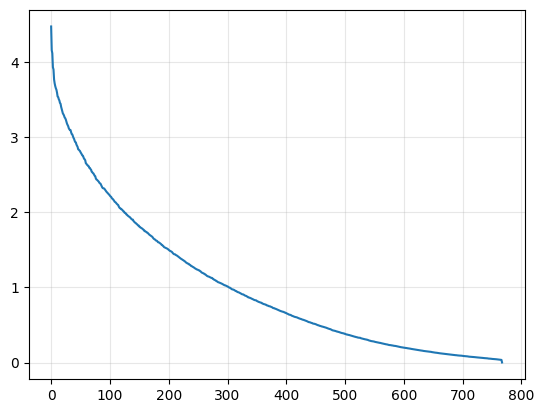

"\nConclusions:\n- These are in some sense lower rank than random matrices\n- They have high-ish singular values (but not that that high); in this case it seems like it's actually quite shearing the space; this might depend a lot\n    on the directionality you go in\n- Bias seems to be much smaller than mean, so it's not just doing mean estimation, which is odd?\n- Indeed the MSE is correct as we report it (probably)---at least the order of magnitude is correct; this means that our layers are not very good;\n    to get a better look into this we should look at the variance explained.\n"

In [30]:
"""
Above the MSEs seem to be too good for the mean estimator, but seem to suck for the regular estimators relative to it. We are going to check what's going on here
in the embeddings on maybe scidocs or smth.

Here we do the following:
1. Pick a pair of layer and then get their MSE by geneating the image of the embeddings set. We then compare this with the train and validation MSEs
    claimed from the training loss as well as the MSEs from the mean estimator. this should give us a sense of how well we are doing.
        - Do this for OLS
        - Do this for the NNLinear
2. For that pair of layers look at the frobenius norm of the weight matrix
    - OLS
    - NNLinear
    - Compare with 30 random layers with; NOTE that the identity should have a frobenius norm of around sqrt(d) -> >>>> 1 (i.e. could be as large as 30+)
"""

print("================== LOADING LINEAR LAYERS ==================")
from safetensors.torch import load_file
import torch
import torch.nn as nn
dataset = "arguana"
model1 = MODEL_NAMES[0]
model2 = MODEL_NAMES[1]
device = "cuda:3"
nn_linear_path = Path(
    "/mnt/align3_drive/adrianoh/dl_final_project_layers/arguana_hf_cartesian_product/" + 
    f"{model1.replace('/', '_')}_{model2.replace('/', '_')}/{dataset}/checkpoints/checkpoint_40.safetensors"
)
ols_linear_path = Path(
    "/mnt/align3_drive/adrianoh/dl_final_project_layers/ols_all_datasets/" + 
    f"{model1.replace('/', '_')}_{model2.replace('/', '_')}/{dataset}/linear_transform.safetensors"
)
assert nn_linear_path.exists()
assert ols_linear_path.exists()
nn_linear_state_dict = load_file(nn_linear_path)
ols_linear_state_dict = load_file(ols_linear_path)
nn_linear = nn.Linear(*reversed(nn_linear_state_dict["weight"].shape)).to(device)
nn_linear.load_state_dict(nn_linear_state_dict)
nn_linear.eval()
assert ols_linear_state_dict['bias'].shape == nn_linear_state_dict['bias'].shape
if nn_linear_state_dict['weight'].shape != ols_linear_state_dict['weight'].shape:
    ols_linear_state_dict['weight'] = ols_linear_state_dict['weight'].T
assert nn_linear_state_dict['bias'].shape == ols_linear_state_dict['bias'].shape
ols_linear = nn.Linear(*reversed(ols_linear_state_dict["weight"].shape)).to(device)
ols_linear.load_state_dict(ols_linear_state_dict)
ols_linear.eval()
print(f"(dimensions were {nn_linear_state_dict['weight'].shape})")
print("================== LOADING EMBEDDINGS ==================")
src_embeddings_validation_path = Path(
    "/mnt/align3_drive/adrianoh/dl_final_project_embeddings/" + 
    f"{model1.replace('/', '_')}/{dataset}/embeddings_corpus_validation.safetensors"
)
src_embeddings_train_path = Path(
    "/mnt/align3_drive/adrianoh/dl_final_project_embeddings/" + 
    f"{model1.replace('/', '_')}/{dataset}/embeddings_corpus_train.safetensors"
)
tgt_embeddings_validation_path = Path(
    "/mnt/align3_drive/adrianoh/dl_final_project_embeddings/" + 
    f"{model2.replace('/', '_')}/{dataset}/embeddings_corpus_validation.safetensors"
)
tgt_embeddings_train_path = Path(
    "/mnt/align3_drive/adrianoh/dl_final_project_embeddings/" + 
    f"{model2.replace('/', '_')}/{dataset}/embeddings_corpus_train.safetensors"
)
assert src_embeddings_validation_path.exists()
assert src_embeddings_train_path.exists()
assert tgt_embeddings_validation_path.exists()
assert tgt_embeddings_train_path.exists()
src_embeddings_validation = load_file(src_embeddings_validation_path)["embeddings"].to(device)
src_embeddings_train = load_file(src_embeddings_train_path)["embeddings"].to(device)
tgt_embeddings_validation = load_file(tgt_embeddings_validation_path)["embeddings"].to(device)
tgt_embeddings_train = load_file(tgt_embeddings_train_path)["embeddings"].to(device)
assert src_embeddings_validation.shape[0] == tgt_embeddings_validation.shape[0]
assert src_embeddings_validation.shape[1] == nn_linear_state_dict["weight"].shape[1]
assert tgt_embeddings_validation.shape[1] == nn_linear_state_dict["weight"].shape[0]
print("================== DONE EMBEDDINGS ==================")
nn_linear_output_validation = nn_linear(src_embeddings_validation) # src -> tgt
nn_linear_mse_validation = (nn_linear_output_validation - tgt_embeddings_validation).pow(2).mean()
nn_linear_output_train = nn_linear(src_embeddings_train) # src -> tgt
nn_linear_mse_train = (nn_linear_output_train - tgt_embeddings_train).pow(2).mean()
ols_linear_output_validation = ols_linear(src_embeddings_validation) # src -> src
ols_linear_mse_validation = (ols_linear_output_validation - tgt_embeddings_validation).pow(2).mean()
ols_linear_output_train = ols_linear(src_embeddings_train) # src -> src
ols_linear_mse_train = (ols_linear_output_train - tgt_embeddings_train).pow(2).mean()
print(f"NNLinear MSE (validation): {nn_linear_mse_validation:.6f}")
print(f"NNLinear MSE (train): {nn_linear_mse_train:.6f}")
print(f"OLSLinear MSE (validation): {ols_linear_mse_validation:.6f}")
print(f"OLSLinear MSE (train): {ols_linear_mse_train:.6f}")
print("="*40 + " COMPARING TO TRAINSET-BASED VALIDATION ESTIMATORS " + "="*40)
train_tgt_embeddings_mean = tgt_embeddings_train.mean(dim=0)
train_tgt_embeddings_mean_mse_validation = (train_tgt_embeddings_mean - tgt_embeddings_validation).pow(2).mean() # NOTE: VALIDATION IS USED HERE
train_tgt_embeddings_mean_mse_train = (train_tgt_embeddings_mean - tgt_embeddings_train).pow(2).mean()
print(f"[TRAIN ACC] Trainset-based validation estimator MSE: {train_tgt_embeddings_mean_mse_train:.6f}") # <---- very similar      v
print(f"[VALID ACC] Trainset-based validation estimator MSE: {train_tgt_embeddings_mean_mse_validation:.6f}") # <---- very similar ^
print("="*40 + "LOOKING AT PROPERTIES OF THE MATRICES " + "="*40)
ols_linear_frobenius_norm = ols_linear.weight.norm(p=2)
nn_linear_frobenius_norm = nn_linear.weight.norm(p=2)
randn_mat_frobenius_norms = torch.tensor([torch.randn_like(ols_linear.weight).norm(p=2) for _ in range(30)])
rand_lin_mat_frobenius_norms = torch.tensor([nn.Linear(*reversed(nn_linear_state_dict["weight"].shape)).weight.norm(p=2) for _ in range(30)])
print("---- Weight (Frobenius norm) ----")
print(f"NNLinear Frobenius norm: {nn_linear_frobenius_norm:.6f}")
print(f"OLSLinear Frobenius norm: {ols_linear_frobenius_norm:.6f}")
print(f"Random N(0, 1) Matrix Frobenius norm: {randn_mat_frobenius_norms.mean():.6f} ± {randn_mat_frobenius_norms.std():.6f}")
print(f"Random NNLinear Matrix Frobenius norm: {rand_lin_mat_frobenius_norms.mean():.6f} ± {rand_lin_mat_frobenius_norms.std():.6f}")
ols_bias_norm = ols_linear.bias.norm(p=2)
nn_bias_norm = nn_linear.bias.norm(p=2)
rand_mat_bias_norms = torch.tensor([torch.randn_like(ols_linear.bias).norm(p=2) for _ in range(30)])
rand_lin_mat_bias_norms = torch.tensor([nn.Linear(*reversed(nn_linear_state_dict["weight"].shape)).bias.norm(p=2) for _ in range(30)])
print("---- Bias ----")
print(f"OLSLinear bias norm: {ols_bias_norm:.6f}")
print(f"NNLinear bias norm: {nn_bias_norm:.6f}")
print(f"Random N(0, 1) Matrix bias norm: {rand_mat_bias_norms.mean().item():.6f} ± {rand_mat_bias_norms.std().item():.6f}")
print(f"Random NNLinear Matrix bias norm: {rand_lin_mat_bias_norms.mean().item():.6f} ± {rand_lin_mat_bias_norms.std().item():.6f}")
print(f"OLSLinear bias mean: {ols_linear.bias.mean().item():.6f}")
print(f"NNLinear bias mean: {nn_linear.bias.mean().item():.6f}")
print(f"Target mean norm: {tgt_embeddings_train.mean(dim=0).norm(p=2).item():.6f}")
print("---- Weight (Eigenvalues, Singular values, Spectral Properties) ----")
# plotting singular values and eigenvectors
singular_values = torch.svd(ols_linear.weight).S.cpu().detach().numpy()
import matplotlib.pyplot as plt
# print(type(singular_values), singular_values.shape) # [DEBUG]
print("Top singular values:", ", ".join(map(str, singular_values[:10])))
print("50th, 100th, 150th, 200th, 250th, 500th, 700th singular values:", ", ".join(map(str, [singular_values[49], singular_values[99], singular_values[149], singular_values[199], singular_values[249], singular_values[499], singular_values[699]])))
print("OLS Matrix rank:", np.linalg.matrix_rank(ols_linear.weight.cpu().detach().numpy()))
print("NNMatrix rank:", np.linalg.matrix_rank(nn_linear.weight.cpu().detach().numpy()))
randn_matrix_ranks = torch.tensor([float(np.linalg.matrix_rank(torch.randn_like(ols_linear.weight).cpu().detach().numpy())) for _ in tqdm.trange(15)])
rand_lin_matrix_ranks = torch.tensor([float(np.linalg.matrix_rank(nn.Linear(*reversed(nn_linear_state_dict["weight"].shape)).weight.cpu().detach().numpy())) for _ in tqdm.trange(15)])
print("Random matrix rank:", randn_matrix_ranks.mean().item(), "±", randn_matrix_ranks.std().item())
print("Random NNLinear matrix rank:", rand_lin_matrix_ranks.mean().item(), "±", rand_lin_matrix_ranks.std().item())

def soft_rank(matrix: torch.Tensor, thresh: float = 1e-4) -> float:
    singular_values = torch.svd(matrix).S.cpu().detach().numpy()
    singular_values_above_thresh = singular_values > thresh
    s = singular_values_above_thresh.sum()
    assert 0 <= s <= singular_values.shape[0], f"s: {s}, singular_values.shape[0]: {singular_values.shape[0]}"
    return s

print("======== SOFT RANKING ========")
for thresh in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 3.0, 10.0]:
    print(f"Soft rank OLS ({thresh}):", soft_rank(ols_linear.weight, thresh))
    print(f"Soft rank NNLinear ({thresh}):", soft_rank(nn_linear.weight, thresh))
    randn_soft_ranks = torch.tensor([float(soft_rank(torch.randn_like(ols_linear.weight), thresh)) for _ in tqdm.trange(15)])
    rand_lin_soft_ranks = torch.tensor([float(soft_rank(nn.Linear(*reversed(nn_linear_state_dict["weight"].shape)).weight, thresh)) for _ in tqdm.trange(15)])
    print(f"Random matrix soft rank ({thresh}):", randn_soft_ranks.mean().item(), "±", randn_soft_ranks.std().item())
    print(f"Random NNLinear matrix soft rank ({thresh}):", rand_lin_soft_ranks.mean().item(), "±", rand_lin_soft_ranks.std().item())
print("="*40 + " DONE SOFT RANKING " + "="*40)
print("\n---- Rank Measures [Generated by Claude + O1] ----")

# Calculate stable rank
def stable_rank(matrix: torch.Tensor) -> float:
    frob_norm = matrix.norm(p='fro')
    spec_norm = torch.svd(matrix).S[0]  # Largest singular value
    return (frob_norm / spec_norm).item() ** 2

# Calculate effective rank
def effective_rank(matrix: torch.Tensor) -> float:
    singular_values = torch.svd(matrix).S
    # Normalize squared singular values to get probability-like weights
    squared_sv = singular_values ** 2
    total = squared_sv.sum()
    probs = squared_sv / total
    # Calculate entropy, handling 0 probabilities
    entropy = 0.0
    for p in probs:
        if p > 0:  # Avoid log(0)
            entropy -= p * torch.log(p)
    return torch.exp(entropy).item()

# Calculate nuclear norm ratio
def nuclear_norm_ratio(matrix: torch.Tensor) -> float:
    singular_values = torch.svd(matrix).S
    nuclear_norm = singular_values.sum()
    spec_norm = singular_values[0]
    return (nuclear_norm / spec_norm).item()

# Calculate measures for OLS and NNLinear
print("\nOLS Linear:")
print(f"Stable Rank: {stable_rank(ols_linear.weight):.4f}")
print(f"Effective Rank: {effective_rank(ols_linear.weight):.4f}")
print(f"Nuclear Norm Ratio: {nuclear_norm_ratio(ols_linear.weight):.4f}")
print("----")
print("\nNN Linear:")
print(f"Stable Rank: {stable_rank(nn_linear.weight):.4f}")
print(f"Effective Rank: {effective_rank(nn_linear.weight):.4f}")
print(f"Nuclear Norm Ratio: {nuclear_norm_ratio(nn_linear.weight):.4f}")
print("----")

# Calculate statistics for random matrices
print("\nRandom N(0,1) Matrix (mean ± std):")
randn_stable_ranks = torch.tensor([stable_rank(torch.randn_like(ols_linear.weight)) for _ in tqdm.trange(30)])
randn_effective_ranks = torch.tensor([effective_rank(torch.randn_like(ols_linear.weight)) for _ in tqdm.trange(30)])
randn_nuclear_ratios = torch.tensor([nuclear_norm_ratio(torch.randn_like(ols_linear.weight)) for _ in tqdm.trange(30)])

print(f"Stable Rank: {randn_stable_ranks.mean():.4f} ± {randn_stable_ranks.std():.4f}")
print(f"Effective Rank: {randn_effective_ranks.mean():.4f} ± {randn_effective_ranks.std():.4f}")
print(f"Nuclear Norm Ratio: {randn_nuclear_ratios.mean():.4f} ± {randn_nuclear_ratios.std():.4f}")

print("\nRandom NNLinear Matrix (mean ± std):")
rand_lin_stable_ranks = torch.tensor([stable_rank(nn.Linear(*reversed(nn_linear_state_dict["weight"].shape)).weight) for _ in tqdm.trange(30)])
rand_lin_effective_ranks = torch.tensor([effective_rank(nn.Linear(*reversed(nn_linear_state_dict["weight"].shape)).weight) for _ in tqdm.trange(30)])
rand_lin_nuclear_ratios = torch.tensor([nuclear_norm_ratio(nn.Linear(*reversed(nn_linear_state_dict["weight"].shape)).weight) for _ in tqdm.trange(30)])

print(f"Stable Rank: {rand_lin_stable_ranks.mean():.4f} ± {rand_lin_stable_ranks.std():.4f}")
print(f"Effective Rank: {rand_lin_effective_ranks.mean():.4f} ± {rand_lin_effective_ranks.std():.4f}")
print(f"Nuclear Norm Ratio: {rand_lin_nuclear_ratios.mean():.4f} ± {rand_lin_nuclear_ratios.std():.4f}")

plt.plot(singular_values)
plt.show()
"""
Conclusions:
- These are in some sense lower rank than random matrices
- They have high-ish singular values (but not that that high); in this case it seems like it's actually quite shearing the space; this might depend a lot
    on the directionality you go in
- Bias seems to be much smaller than mean, so it's not just doing mean estimation, which is odd?
- Indeed the MSE is correct as we report it (probably)---at least the order of magnitude is correct; this means that our layers are not very good;
    to get a better look into this we should look at the variance explained.
"""

In [31]:
import einops
all_variances_tables = {dataset_name: -torch.ones(len(DESIRED_MODEL_ORDER_NAMES) + 2, len(DESIRED_MODEL_ORDER_NAMES) + 2) for dataset_name in DATASETS}
all_abs_variations_tables = {dataset_name: -torch.ones(len(DESIRED_MODEL_ORDER_NAMES) + 2, len(DESIRED_MODEL_ORDER_NAMES) + 2) for dataset_name in DATASETS}
# This is supposed to be like a table version of:
# - all_variances_train,
# - all_variances_validation,
# - all_mse_wrt_gaussian01_train,
# - all_mse_wrt_gaussian01_validation
#
for dataset in DATASETS:
    # l48fndksoso---------- NOTE src = row, tgt = col (search with this key to find the evidence)
    all_v = torch.tensor([all_variances_validation[dataset, model] for model in DESIRED_MODEL_ORDER_NAMES]).squeeze()
    assert all_v.max().item() != all_v.min().item(), f"all_v.max(): {all_v.max().item()}, all_v.min(): {all_v.min().item()}"
    assert len(all_v.shape) == 1
    all_v = torch.cat([all_v, torch.tensor([-1, -1.0])], dim=0) # add a dummy
    all_av = torch.tensor([all_abs_variations_validation[dataset, model] for model in DESIRED_MODEL_ORDER_NAMES]).squeeze()
    assert all_av.max().item() != all_av.min().item()
    assert len(all_av.shape) == 1
    all_av = torch.cat([all_av, torch.tensor([-1, -1.0])], dim=0) # add a dummy
    assert len(all_v.shape) == len(all_av.shape) == 1
    assert all_v.shape[0] == all_av.shape[0] == len(DESIRED_MODEL_ORDER_NAMES) + 2, f"all_v.shape: {all_v.shape}, all_av.shape: {all_av.shape}, len(DESIRED_MODEL_ORDER_NAMES): {len(DESIRED_MODEL_ORDER_NAMES)}"
    all_variances_tables[dataset][:] = einops.rearrange(all_v, "d -> d 1") # broadcast along row (i.e. diff column is same)
    all_abs_variations_tables[dataset][:] = einops.rearrange(all_av, "d -> d 1") # ^
    # NOTE: now the top column is still -1
    assert all_variances_tables[dataset][-2:].min() == all_variances_tables[dataset][-2:].max() == -1.0
    assert all_abs_variations_tables[dataset][-2:].min() == all_abs_variations_tables[dataset][-2:].max() == -1.0
    all_variances_tables[dataset][-2:] = einops.rearrange(all_v, "d -> 1 d") # NOTE the division here SHOULD lead to 0
    all_abs_variations_tables[dataset][-2:] = einops.rearrange(all_av, "d -> 1 d") # ^
    assert all_variances_tables[dataset][-2:, -2:].min() == all_variances_tables[dataset][-2:, -2:].max() == -1.0
    assert all_abs_variations_tables[dataset][-2:, -2:].min() == all_abs_variations_tables[dataset][-2:, -2:].max() == -1.0
    all_variances_tables[dataset][-2:, -2:] = torch.ones(2, 2) # We will be dividing, dividing by 1 is a NoOP
    all_abs_variations_tables[dataset][-2:, -2:] = torch.ones(2, 2) # ^

#### SANITY CHECK VALUES ####
for dataset_name in DATASETS:
    assert all_variances_tables[dataset_name].min() > 0
    assert all_abs_variations_tables[dataset_name].min() > 0
#### SANITY CHECK TABLES ####
for _dict, dict_name in [
    # NOTE: ols affine is defined later and we just want to ensure OK
    (nnlinear_dataset2table_validation_mse, "nnlinear"), (nnlinear_dataset2table_validation_mae, "nnlinear"), 
]:
    for dataset, table in _dict.items():
        if (table.shape[0] + 2, table.shape[1] + 2) != all_variances_tables[dataset].shape:
            print(f"WARNING: table {dataset} {dict_name} has shape {table.shape} but all_variances_tables[dataset] has shape {all_variances_tables[dataset].shape}")
            raise ValueError
printme = all_variances_tables["arguana"]
from tabulate import tabulate
import numpy as np

# Convert to numpy array and format with scientific notation
formatted_table = np.array([[f"{x:.4e}" for x in row] for row in printme.numpy()])
print("Sanity check table:")
print(tabulate(formatted_table, tablefmt='grid'))




Sanity check table:
+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  | 0.0011727  |
+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959 | 0.00056959

In [36]:
"""
NN LINEAR VISUALIZATION
"""
# Path.cwd() # [DEBUG] -> in commands
# plot without log


def get_table_with_controls_default_settings(
    table: torch.Tensor,
    dataset_name: str,
    use_mse: bool = True,
) -> Tuple[torch.Tensor, List[str], torch.Tensor]:
    if use_mse:
        return get_table_with_controls(
            table,
            dataset_name,
            all_variances_train, # default
            all_variances_validation, # default
            all_mse_wrt_gaussian01_train, # default
            all_mse_wrt_gaussian01_validation, # default
            DESIRED_MODEL_ORDER_NAMES, # default
            sort_permutation, # default
            diagonal_value=0.0, # default
        )
    else:
        return get_table_with_controls(
            table,
            dataset_name,
            all_abs_variations_train, # default
            all_abs_variations_validation, # default
            all_mae_wrt_gaussian01_train, # default
            all_mae_wrt_gaussian01_validation, # default
            DESIRED_MODEL_ORDER_NAMES, # default
            sort_permutation, # default
            diagonal_value=0.0, # default
        )

import shutil
plots_folder = Path.cwd().parent / "plots"
CLEAR_PREVIOUS_PLOTS = True
if CLEAR_PREVIOUS_PLOTS and plots_folder.exists():
    print("Clearing previous plots")
    shutil.rmtree(plots_folder)
plots_folder.mkdir(parents=True, exist_ok=True)
DISPLAY = True
for dataset_name in tqdm.tqdm(DATASETS):
    # _ = visualize_plt_heatmap(
    #     dataset_name,
    #     nnlinear_dataset2table_validation_mse[dataset_name],
    #     nnlinear_dataset2table_validation_mae[dataset_name],
    #     use_log_plot=False,
    #     save_path=plots_folder / f"{dataset_name}_nnlinear_msemae_withoutlog.png", # _ seperates
    #     show_plot=DISPLAY
    # )
    # def get_table_with_controls(
    #     table: torch.Tensor, 
    #     dataset_name: str, 
    #     all_variances_train: Dict[Tuple[str, str], float], 
    #     all_variances_validation: Dict[Tuple[str, str], float], 
    #     all_mse_wrt_gaussian01_train: Dict[Tuple[str, str], float], 
    #     all_mse_wrt_gaussian01_validation: Dict[Tuple[str, str], float],
    #     desired_model_order_names: List[str],
    #     permutation: torch.Tensor,
    #     diagonal_value: float = 0.0,
    # ) -> Tuple[torch.Tensor, List[str]]:
    table_mse = nnlinear_dataset2table_validation_mse[dataset_name]
    table_mae = nnlinear_dataset2table_validation_mae[dataset_name]
    ctrl_table_validation_mse, ctrl_idx2model_mse, ctrl_permutation_mse = get_table_with_controls_default_settings(
        table_mse,
        dataset_name,
        use_mse=True,
    )
    assert ctrl_table_validation_mse.shape == (table_mse.shape[0] + 2, table_mse.shape[1] + 2)
    ctrl_table_validation_mae, ctrl_idx2model_mae, ctrl_permutation_mae = get_table_with_controls_default_settings(
        table_mae,
        dataset_name,
        use_mse=False,
    )
    assert ctrl_table_validation_mae.shape == (table_mae.shape[0] + 2, table_mae.shape[1] + 2)
    fig_mse_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mse, dataset_name, "nnlinear", ctrl_table_validation_mse, do_log=False, sort_permutation=ctrl_permutation_mse, metric_name="MSE")
    fig_mae_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mae, dataset_name, "nnlinear", ctrl_table_validation_mae, do_log=False, sort_permutation=ctrl_permutation_mae, metric_name="MAE")
    fig_mse_withlog = gatlen_default_heatmap_plot(ctrl_idx2model_mse, dataset_name, "nnlinear", ctrl_table_validation_mse, do_log=True, sort_permutation=ctrl_permutation_mse, metric_name="MSE")
    fig_mae_withlog = gatlen_default_heatmap_plot(ctrl_idx2model_mae, dataset_name, "nnlinear", ctrl_table_validation_mae, do_log=True, sort_permutation=ctrl_permutation_mae, metric_name="MAE")
    save_figure(fig_mse_withoutlog, f"{dataset_name}_nnlinear_mse_withoutlog_validation")
    save_figure(fig_mae_withoutlog, f"{dataset_name}_nnlinear_mae_withoutlog_validation")
    save_figure(fig_mse_withlog, f"{dataset_name}_nnlinear_mse_withlog_validation")
    save_figure(fig_mae_withlog, f"{dataset_name}_nnlinear_mae_withlog_validation")

    # Get % explained or not
    # NOTE that this should include in the extra columns, the variance of the dataset, etc...
    # NOTE that for the mean estimator we expect R2 to be 0 and for the N(0, 1) estimator we expected R^2 < 1 actually (worse than mean estimator)
    r2_table_mse = 1 - ctrl_table_validation_mse / all_variances_tables[dataset_name]
    r2_table_mae = 1 - ctrl_table_validation_mae / all_abs_variations_tables[dataset_name]
    fig_r2_mse_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mse, dataset_name, "nnlinear", r2_table_mse, do_log=False, sort_permutation=ctrl_permutation_mse, metric_name="R2")
    fig_r2_mae_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mae, dataset_name, "nnlinear", r2_table_mae, do_log=False, sort_permutation=ctrl_permutation_mae, metric_name="Percent MAE Explained")
    save_figure(fig_r2_mse_withoutlog, f"{dataset_name}_nnlinear_r2_mse_withoutlog_validation")
    save_figure(fig_r2_mae_withoutlog, f"{dataset_name}_nnlinear_r2_mae_withoutlog_validation")
print("Done")

Clearing previous plots


  0%|          | 0/6 [00:00<?, ?it/s]2024-12-12 23:59:45.284 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-12 23:59:45.285 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-12 23:59:45.289 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-12 23:59:45.289 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-12 23:59:45.290 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-12 23:59:45.294 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-12 23:59:45.295 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-12 23:59:45.295 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-12 23:59:45.299 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-12 23:59:45.300 | INFO     | __main__:visualiz

Done


In [24]:
# # plot with log
# DISPLAY = False
# for dataset_name in tqdm.tqdm(DATASETS):
#     _ = visualize_plt_heatmap(
#         dataset_name,
#         nnlinear_dataset2table_validation_mse[dataset_name],
#         nnlinear_dataset2table_validation_mae[dataset_name],
#         use_log_plot=True,
#         save_path=plots_folder / f"{dataset_name}_nnlinear_msemae_withlog.png", # _ seperates
#         show_plot=DISPLAY
#     )
# print("Done")


In [37]:
"""
OLS VISUALIZATION
"""
(
    ols_model2idx,
    ols_idx2model,
    ols_dataset2table_train_mse,
    ols_dataset2table_validation_mse,
    ols_dataset2table_train_mae,
    ols_dataset2table_validation_mae
) = creator2.get_all_table_elements()
# plot with log
DISPLAY = False
for dataset_name in DATASETS:
    # visualize_plt_heatmap(
    #     dataset_name,
    #     ols_dataset2table_validation_mse[dataset_name],
    #     ols_dataset2table_validation_mae[dataset_name],
    #     use_log_plot=True,
    #     save_path=plots_folder / f"{dataset_name}_olsaffine_msemae_withlog.png", # _ seperates
    #     show_plot=DISPLAY
    # )
    ctrl_table_validation_mse, ctrl_idx2model_mse, ctrl_permutation_mse = get_table_with_controls_default_settings(
        ols_dataset2table_validation_mse[dataset_name],
        dataset_name,
        use_mse=True,
    )
    ctrl_table_validation_mae, ctrl_idx2model_mae, ctrl_permutation_mae = get_table_with_controls_default_settings(
        ols_dataset2table_validation_mae[dataset_name],
        dataset_name,
        use_mse=False,
    )
    fig_mse_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mse, dataset_name, "olsaffine", ctrl_table_validation_mse, do_log=False, sort_permutation=ctrl_permutation_mse, metric_name="MSE")
    fig_mae_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mae, dataset_name, "olsaffine", ctrl_table_validation_mae, do_log=False, sort_permutation=ctrl_permutation_mae, metric_name="MAE")
    fig_mse_withlog = gatlen_default_heatmap_plot(ctrl_idx2model_mse, dataset_name, "olsaffine", ctrl_table_validation_mse, do_log=True, sort_permutation=ctrl_permutation_mse, metric_name="MSE")
    fig_mae_withlog = gatlen_default_heatmap_plot(ctrl_idx2model_mae, dataset_name, "olsaffine", ctrl_table_validation_mae, do_log=True, sort_permutation=ctrl_permutation_mae, metric_name="MAE")
    save_figure(fig_mse_withoutlog, f"{dataset_name}_olsaffine_mse_withoutlog_validation")
    save_figure(fig_mae_withoutlog, f"{dataset_name}_olsaffine_mae_withoutlog_validation")
    save_figure(fig_mse_withlog, f"{dataset_name}_olsaffine_mse_withlog_validation")
    save_figure(fig_mae_withlog, f"{dataset_name}_olsaffine_mae_withlog_validation")

    # Get % explained or not
    r2_table_mse = 1 - ctrl_table_validation_mse / all_variances_tables[dataset_name]
    r2_table_mae = 1 - ctrl_table_validation_mae / all_abs_variations_tables[dataset_name]
    fig_r2_mse_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mse, dataset_name, "olsaffine", r2_table_mse, do_log=False, sort_permutation=ctrl_permutation_mse, metric_name="R2")
    fig_r2_mae_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mae, dataset_name, "olsaffine", r2_table_mae, do_log=False, sort_permutation=ctrl_permutation_mae, metric_name="Percent MAE Explained")
    save_figure(fig_r2_mse_withoutlog, f"{dataset_name}_olsaffine_r2_mse_withoutlog_validation")
    save_figure(fig_r2_mae_withoutlog, f"{dataset_name}_olsaffine_r2_mae_withoutlog_validation")
print("Done")
# for dataset_name in DATASETS:
#     visualize_plt_heatmap(
#         dataset_name,
#         ols_dataset2table_validation_mse[dataset_name],
#         ols_dataset2table_validation_mae[dataset_name],
#         use_log_plot=False,
#         save_path=plots_folder / f"{dataset_name}_olsaffine_msemae_withoutlog.png", # _ seperates
#         show_plot=DISPLAY
#     )



100%|██████████| 1632/1632 [00:00<00:00, 19583.79it/s]
2024-12-13 00:00:01.125 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-13 00:00:01.126 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-13 00:00:01.131 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-13 00:00:01.132 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-13 00:00:01.132 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-13 00:00:01.136 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-13 00:00:01.137 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-13 00:00:01.137 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-13 00:00:01.141 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-13 00:00:01.142 | INFO     |

Done


In [39]:
"""
AGGREGATES VISUALIZATION
"""
import einops
dataset_sizes = {
    "arguana": 10000,
    "fiqa": 50000,
    "scidocs": 25000,
    "nfcorpus": 5000,
    "hotpotqa": 100000,
    "trec-covid": 20000,
}
proportions = torch.tensor([dataset_sizes[x] for x in DATASETS])
proportions = proportions / proportions.sum()
proportions = einops.rearrange(proportions, "d -> d 1 1")
assert proportions.sum() == 1.0
# 1. Stack
nnlinear_mse_validation_tables = torch.stack([nnlinear_dataset2table_validation_mse[x] for x in DATASETS])
nnlinear_mse_train_tables = torch.stack([nnlinear_dataset2table_train_mse[x] for x in DATASETS])
nnlinear_mae_validation_tables = torch.stack([nnlinear_dataset2table_validation_mae[x] for x in DATASETS])
nnlinear_mae_train_tables = torch.stack([nnlinear_dataset2table_train_mae[x] for x in DATASETS])
ols_mse_validation_tables = torch.stack([ols_dataset2table_validation_mse[x] for x in DATASETS])
ols_mse_train_tables = torch.stack([ols_dataset2table_train_mse[x] for x in DATASETS])
ols_mae_validation_tables = torch.stack([ols_dataset2table_validation_mae[x] for x in DATASETS])
ols_mae_train_tables = torch.stack([ols_dataset2table_train_mae[x] for x in DATASETS])
# 2. Scale
nnlinear_scaled_mse_validation_tables = nnlinear_mse_validation_tables * proportions
nnlinear_scaled_mse_train_tables = nnlinear_mse_train_tables * proportions
nnlinear_scaled_mae_validation_tables = nnlinear_mae_validation_tables * proportions
nnlinear_scaled_mae_train_tables = nnlinear_mae_train_tables * proportions
ols_scaled_mse_validation_tables = ols_mse_validation_tables * proportions
ols_scaled_mse_train_tables = ols_mse_train_tables * proportions
ols_scaled_mae_validation_tables = ols_mae_validation_tables * proportions
ols_scaled_mae_train_tables = ols_mae_train_tables * proportions
# 3. Sum
nnlinear_mean_mse_validation_table = nnlinear_scaled_mse_validation_tables.sum(dim=0)
nnlinear_mean_mse_train_table = nnlinear_scaled_mse_train_tables.sum(dim=0)
nnlinear_mean_mae_validation_table = nnlinear_scaled_mae_validation_tables.sum(dim=0)
nnlinear_mean_mae_train_table = nnlinear_scaled_mae_train_tables.sum(dim=0)
ols_mean_mse_validation_table = ols_scaled_mse_validation_tables.sum(dim=0)
ols_mean_mse_train_table = ols_scaled_mse_train_tables.sum(dim=0)
ols_mean_mae_validation_table = ols_scaled_mae_validation_tables.sum(dim=0)
ols_mean_mae_train_table = ols_scaled_mae_train_tables.sum(dim=0)
assert nnlinear_mean_mse_validation_table.shape == nnlinear_mean_mse_train_table.shape == nnlinear_mean_mae_validation_table.shape == nnlinear_mean_mae_train_table.shape == (len(MODEL_NAMES), len(MODEL_NAMES))
assert ols_mean_mse_validation_table.shape == ols_mean_mse_train_table.shape == ols_mean_mae_validation_table.shape == ols_mean_mae_train_table.shape == (len(MODEL_NAMES), len(MODEL_NAMES))
# 4. Plot
DISPLAY = False
# visualize_plt_heatmap(
#     "mean",
#     nnlinear_mean_mse_validation_table,
#     nnlinear_mean_mae_validation_table,
#     use_log_plot=False,
#     save_path=plots_folder / f"weightedmean_nnlinear_msemae_withoutlog.png",
#     show_plot=DISPLAY
# )
# visualize_plt_heatmap(
#     "mean",
#     ols_mean_mse_validation_table,
#     ols_mean_mae_validation_table,
#     use_log_plot=False,
#     save_path=plots_folder / f"weightedmean_olsaffine_msemae_withoutlog.png",
#     show_plot=DISPLAY
# )
################ GET THE AVERAGES OF CONTROLS TABLES ################
GLOBAL_NAME = "MeanOfAllDatasets"
assert GLOBAL_NAME not in all_variances_train
assert GLOBAL_NAME not in all_variances_validation
assert GLOBAL_NAME not in all_mse_wrt_gaussian01_train
assert GLOBAL_NAME not in all_mse_wrt_gaussian01_validation
combos = list(itertools.product(MODEL_NAMES, MODEL_NAMES))
for _dict in [
    all_variances_train,
    all_variances_validation,
    all_mse_wrt_gaussian01_train,
    all_mse_wrt_gaussian01_validation,
    all_abs_variations_train,
    all_abs_variations_validation,
    all_mae_wrt_gaussian01_train,
    all_mae_wrt_gaussian01_validation,
]:
    for model in tqdm.tqdm(MODEL_NAMES):
        vals = []
        for dataset in DATASETS:
            vals.append(_dict[dataset, model])
        mean_val = torch.tensor(vals).mean() # arithmetic should be OK for these
        _dict[GLOBAL_NAME, model] = mean_val

################ GET THE CONTROL TABLES ################
ctrl_table_validation_mse, ctrl_idx2model_mse, ctrl_permutation_mse = get_table_with_controls(
    ols_mean_mse_validation_table,
    GLOBAL_NAME,
    all_variances_train, # Default OK here
    all_variances_validation, # Default OK here
    all_mse_wrt_gaussian01_train, # Default OK here
    all_mse_wrt_gaussian01_validation, # Default OK here
    desired_model_order_names=MODEL_NAMES, # Default OK here
    permutation=sort_permutation, # Default OK here
    diagonal_value=0.0, # Default OK here
)
ctrl_table_validation_mae, ctrl_idx2model_mae, ctrl_permutation_mae = get_table_with_controls(
    ols_mean_mae_validation_table,
    GLOBAL_NAME,
    all_abs_variations_train, # Default OK here
    all_abs_variations_validation, # Default OK here
    all_mae_wrt_gaussian01_train, # Default OK here
    all_mae_wrt_gaussian01_validation, # Default OK here
    desired_model_order_names=MODEL_NAMES, # Default OK here
    permutation=sort_permutation, # Default OK here
    diagonal_value=0.0, # Default OK here
)
fig_mse_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mse, "mean", "olsaffine", ctrl_table_validation_mse, do_log=False, sort_permutation=ctrl_permutation_mse, metric_name="MSE")
fig_mae_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mae, "mean", "olsaffine", ctrl_table_validation_mae, do_log=False, sort_permutation=ctrl_permutation_mae, metric_name="MAE")
fig_mse_withlog = gatlen_default_heatmap_plot(ctrl_idx2model_mse, "mean", "olsaffine", ctrl_table_validation_mse, do_log=True, sort_permutation=ctrl_permutation_mse, metric_name="MSE")
fig_mae_withlog = gatlen_default_heatmap_plot(ctrl_idx2model_mae, "mean", "olsaffine", ctrl_table_validation_mae, do_log=True, sort_permutation=ctrl_permutation_mae, metric_name="MAE")
save_figure(fig_mse_withoutlog, f"weightedmean_olsaffine_mse_withoutlog_validation")
save_figure(fig_mae_withoutlog, f"weightedmean_olsaffine_mae_withoutlog_validation")
save_figure(fig_mse_withlog, f"weightedmean_olsaffine_mse_withlog_validation")
save_figure(fig_mae_withlog, f"weightedmean_olsaffine_mae_withlog_validation")

# Get % explained or not
all_variances_table = (torch.stack([all_variances_tables[dataset_name] for dataset_name in DATASETS]) * proportions).mean(dim=0)
all_abs_variations_table = (torch.stack([all_abs_variations_tables[dataset_name] for dataset_name in DATASETS]) * proportions).mean(dim=0)
r2_table_mse = 1 - ctrl_table_validation_mse / all_variances_table
r2_table_mae = 1 - ctrl_table_validation_mae / all_abs_variations_table
fig_r2_mse_withoutlog = gatlen_default_heatmap_plot(ctrl_idx2model_mse, dataset_name, "nnlinear", r2_table_mse, do_log=False, sort_permutation=ctrl_permutation_mse, metric_name="R2")
fig_r2_mae_withoutlog = gatlen_default_heatmap_plot(ctrl_table_validation_mae, "mean", "olsaffine", r2_table_mae, do_log=False, sort_permutation=ctrl_permutation_mae, metric_name="Percent MAE Explained")
save_figure(fig_r2_mse_withoutlog, f"weightedmean_olsaffine_r2_mse_withoutlog_validation")
save_figure(fig_r2_mae_withoutlog, f"weightedmean_olsaffine_r2_mae_withoutlog_validation")


100%|██████████| 17/17 [00:00<00:00, 21393.09it/s]
2024-12-13 00:00:51.265 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-13 00:00:51.265 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-13 00:00:51.277 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-13 00:00:51.278 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-13 00:00:51.278 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-13 00:00:51.288 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-13 00:00:51.289 | INFO     | __main__:visualize_heatmap:127 - Starting heatmap visualization process
2024-12-13 00:00:51.290 | INFO     | __main__:_plot_heatmap:52 - Creating heatmap visualization...
2024-12-13 00:00:51.299 | SUCCESS  | __main__:_plot_heatmap:101 - Heatmap created successfully
2024-12-13 00:00:51.300 | INFO     | __m

(PosixPath('data/figs/html/weightedmean_olsaffine_r2_mae_withoutlog_validation.html'),
 PosixPath('data/figs/imgs/weightedmean_olsaffine_r2_mae_withoutlog_validation.png'))

In [40]:
# NOTE we expect each dataset to get 6 different images generated (6 datasets) and that happens twice: OLS and NNLinear;
# next we also get 6 aggregates
assert (Path.cwd() / "data" / "figs" / "imgs").exists()
assert (Path.cwd() / "data" / "figs" / "html").exists()
assert len(list((Path.cwd() / "data" / "figs" / "imgs").iterdir())) == 6 * 6 + 6 * 6 + 6 # 78
assert len(list((Path.cwd() / "data" / "figs" / "html").iterdir())) == 6 * 6 + 6 * 6 + 6 # 78
